# 0. Imports

In [1]:
# 1. Lendos os dados
import pandas as pd
from pathlib import Path

# 2. Pré-processamento dos Textos
import numpy as np
import re
import unicodedata

# 3. Levantamento das palavras
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

from nltk.util import ngrams
from collections import Counter
from tqdm import tqdm

# 4. Outra Abordagem
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sentence_transformers import SentenceTransformer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\EsdrasDaniel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\EsdrasDaniel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\EsdrasDaniel\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# 1. Lendo os dados

In [2]:
path = Path('./data/pgm-dataset-v2.parquet')
df = pd.read_parquet(path)

df.head(3)

,intimacao_conteudo,processo_conteudo,rstREGEX,teorIntimacao,intimacaoPJE,processoPJE,idavisopje,setordestino,Classificacao
0,,,"[{""diligencia"": ""intime-se o Município de Nata...",PODER JUDICIÁRIO ESTADO DO RIO GRANDE DO NORTE...,"{""id"": ""18612632"", ""tipoComunicacao"": ""INT"", ""...","{""Numero"": ""08387198120248205001"", ""Competenci...",18612632,Procuradoria da Sa�de,
1,,,"[{""diligencia"": ""intimado acerca da obrigação ...",PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,"{""id"": ""18629258"", ""tipoComunicacao"": ""INT"", ""...","{""Numero"": ""08464942120228205001"", ""Competenci...",18629258,Procuradoria Administrativa,
2,,,"[{""diligencia"": ""Decido. Compulsando os autos,...",PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,"{""id"": ""18629422"", ""tipoComunicacao"": ""INT"", ""...","{""Numero"": ""08954169320228205001"", ""Competenci...",18629422,CARTORIO,


## 1.1 - Removendo valores nulos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15984 entries, 0 to 15983
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   intimacao_conteudo  15984 non-null  object
 1   processo_conteudo   15984 non-null  object
 2   rstREGEX            15942 non-null  object
 3   teorIntimacao       15942 non-null  object
 4   intimacaoPJE        15942 non-null  object
 5   processoPJE         15942 non-null  object
 6   idavisopje          15356 non-null  object
 7   setordestino        15356 non-null  object
 8   Classificacao       15984 non-null  object
dtypes: object(9)
memory usage: 1.1+ MB


In [4]:
docs_nulos = df.teorIntimacao.isna()

print(f'Temos {docs_nulos.sum()} documentos onde teorIntimação é nulo')

Temos 42 documentos onde teorIntimação é nulo


In [5]:
# Removendo
df.dropna(axis=0, how='any', inplace=True)

## 1.2 - Verificando as Classes

In [6]:
# Substituindo os valores da coluna 'setordestino'

swap_dict = {
    'DEPARTAMENTO DE C�LCULOS E CONTABILIDADE': 'DEPARTAMENTO DE CALCULOS E CONTABILIDADE',
    'Procuradoria da Sa�de': 'Procuradoria da Saude',
    'SETOR DE ADMINISTRA�?O GERAL': 'SETOR DE ADMINISTRACAO GERAL',
    'Procuradoria de Recupera�?o da D�vida Ativa': 'Procuradoria de Recuperacao da Divida Ativa'
}

df['setordestino'].replace(swap_dict, inplace=True)

In [7]:
df.setordestino.value_counts().sum()

setordestino
Procuradoria Administrativa                    4744
APOIO FISCAL                                   4311
Procuradoria Fiscal                            2368
DEPARTAMENTO DE CALCULOS E CONTABILIDADE       1338
Procuradoria Judicial                           976
Chefia Administrativa                           657
Procuradoria da Saude                           443
Chefia Judicial                                 161
Chefia Meio Ambiente                            121
Chefia Patrimonial                              121
Assessoria - Gabinete                            44
Procuradoria do Meio Ambiente                    34
Procuradoria Geral                               22
CHEFIA FISCAL                                     7
CARTORIO                                          4
SETOR DE ADMINISTRACAO GERAL                      2
Procuradoria de Recuperacao da Divida Ativa       2
Procuradoria Geral Substituta                     1
Name: count, dtype: int64

# 2. Pré-processamento dos Textos

In [8]:
stop_words_pt = set(stopwords.words('portuguese'))

padroes = ['[^\w\s]',
        'poder judiciario do estado do rio grande do norte',
        'poder judiciario estado do rio grande do norte',
        'poder judiciario do estado rio grande do norte',
        'poder judiciario estado rio grande do norte',
        'normal', 'false',
            'ptbr', 'xnone',
            'poder', 'judiciario',
            'estado', 'rio', 'grande', 'norte',
            'vara execucao fiscal',
            'tributaria natal',
            'praca sete setembro',
            'cidade alta',
            'natalrn', 'cep',
            'rn', 'natal', '5902530',
            'assinado', 'digitalmente',
            'forma lei', 'n1141906',
            'comarca', 'forum fazendario',
            'juiz djanirito souza moura',
            'data registrada sistema',
            '1141906', 'veft', '59025275', 'email',
            'secuniefttj', 'jusbr',
            'telefone', 'whatsapp',
            '36738671',
            'judiciario', 'natalpraca',
            'setembro', 'cidade', '59025300',
            'rio norte', 'forum fazendario',
            'juiz', 'djanirito souza mouro',
            'praca alto', 'natalrn', 'nao',
    ]

def preprocessamento(text):
    if text == None:
        return text
    
    text_tokens = word_tokenize(text, language='portuguese')

    filtered_text = [word for word in text_tokens if word.lower() not in stop_words_pt and len(word) > 2]
    text = ' '.join(filtered_text)

    # Retira acentos e converte o texto para minúsculo
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII').lower()

    # Retira alguns padrões definidos na lista 'padroes'
    for padrao in padroes:
        text = re.sub(padrao, '', text)

    return text


In [9]:
df['teorIntimacao_clean'] = df['teorIntimacao'].apply(preprocessamento)

df.head(3)

,intimacao_conteudo,processo_conteudo,rstREGEX,teorIntimacao,intimacaoPJE,processoPJE,idavisopje,setordestino,Classificacao,teorIntimacao_clean
0,,,"[{""diligencia"": ""intime-se o Município de Nata...",PODER JUDICIÁRIO ESTADO DO RIO GRANDE DO NORTE...,"{""id"": ""18612632"", ""tipoComunicacao"": ""INT"", ""...","{""Numero"": ""08387198120248205001"", ""Competenci...",18612632,Procuradoria da Saude,,vara infancia juventude processo no083...
1,,,"[{""diligencia"": ""intimado acerca da obrigação ...",PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,"{""id"": ""18629258"", ""tipoComunicacao"": ""INT"", ""...","{""Numero"": ""08464942120228205001"", ""Competenci...",18629258,Procuradoria Administrativa,,3o ado fazenda publica processo 0846494...
2,,,"[{""diligencia"": ""Decido. Compulsando os autos,...",PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,"{""id"": ""18629422"", ""tipoComunicacao"": ""INT"", ""...","{""Numero"": ""08954169320228205001"", ""Competenci...",18629422,CARTORIO,,3a ac forum seabra fagundes 315 rua dout...


# 3. Levantamento dos termos

In [10]:
def count_up_to_n_grams(corpus, n=7):
    """
    Retorna um dicionário com a contagem dos n_gramas até n de um corpus
    """
    n_grams_count = dict()

    i = 1
    while i <= n:
        for text in tqdm(corpus):
            n_gramas = ngrams(text.split(), i)
            counter = Counter(n_gramas)

            for key, value in counter.items():
                key = ' '.join(key)
                if key in n_grams_count:
                    n_grams_count[key] += value
                else:
                    n_grams_count[key] = value
        i += 1


    return dict(sorted(n_grams_count.items(), key=lambda item: item[1], reverse=True))

In [11]:
result_dict = count_up_to_n_grams(df['teorIntimacao_clean'], n=5)

100%|██████████| 15356/15356 [00:09<00:00, 1654.41it/s]


In [12]:
len(result_dict)

5013680

In [ ]:
result_dict

# 4. Outra Abordagem

## 4.1 - Balanceamento das Classes

### 4.1.1 - Removendo classes que possuem pouquíssimos exemplos

In [13]:
# Recuperando as classes
classes = df['setordestino'].unique().tolist()

# Classes que vamos desconsiderar (haviam < 10 textos)
classes_to_disconsider = ('Procuradoria Geral Substituta', 'Procuradoria de Recuperacao da Divida Ativa',
                          'SETOR DE ADMINISTRACAO GERAL', 'CARTORIO', 'CHEFIA FISCAL')

classes = [classe for classe in classes if classe not in classes_to_disconsider]

### 4.1.2 - Recuperando um DataFrame apenas com as classes escolhidas

In [14]:
new_df = df[df['setordestino'].isin(classes)]

### 4.1.3 - Downsampling e Upsampling

In [15]:
def ajustar_amostras(df, classes, n_docs):
    """
    Ajusta o número de amostras (upsampling ou downsampling) para cada classe em um DataFrame.
    
    Parâmetros:
    - df (pd.DataFrame): DataFrame original.
    - classes (str): Nome da coluna que contém as classes.
    - n_docs (int): Número desejado de documentos por classe.
    
    Retorno:
    - pd.DataFrame: DataFrame ajustado com a quantidade especificada de documentos por classe.
    """
    def ajustar_classe(grupo):
        if len(grupo) > n_docs:
            # Downsampling
            return grupo.sample(n_docs, random_state=42)
        else:
            # Upsampling
            return grupo.sample(n_docs, replace=True, random_state=42)
    
    return df.groupby(classes).apply(ajustar_classe).reset_index(drop=True)

df_ajustado = ajustar_amostras(new_df, 'setordestino', n_docs=500)

In [16]:
df_ajustado['setordestino'].value_counts()

setordestino
APOIO FISCAL                                500
Assessoria - Gabinete                       500
Chefia Administrativa                       500
Chefia Judicial                             500
Chefia Meio Ambiente                        500
Chefia Patrimonial                          500
DEPARTAMENTO DE CALCULOS E CONTABILIDADE    500
Procuradoria Administrativa                 500
Procuradoria Fiscal                         500
Procuradoria Geral                          500
Procuradoria Judicial                       500
Procuradoria da Saude                       500
Procuradoria do Meio Ambiente               500
Name: count, dtype: int64

## 4.2 - Train Test Split

In [17]:
X = df_ajustado['teorIntimacao_clean'].to_numpy()
y = df_ajustado['setordestino'].to_numpy()

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 4.3 - Feature Extraction

In [18]:
tfidf_vectorizer = TfidfVectorizer(min_df=0.005, ngram_range=(1,2))

# Fazendo o fitting nos dados de treinamento apenas e vetorizando-os
X_train = tfidf_vectorizer.fit_transform(X_train_text)

# Fazendo a vetorização dos dados de teste
X_test = tfidf_vectorizer.transform(X_test_text)

print(f'Shape do trainamento: {X_train.shape}')
print(f'Shape do teste: {X_test.shape}')

Shape do trainamento: (4550, 15298)
Shape do teste: (1950, 15298)


## 4.4 - Técnicas de Classificação

In [19]:
def plot_confusion_matrix(y_test, y_pred, class_names):
    # Calcula a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    
    # Normaliza a matriz para valores entre 0 e 1
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Cria o gráfico
    plt.figure(figsize=(12, 10))
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confusão', fontsize=16)
    plt.colorbar()
    
    # Adiciona rótulos
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, fontsize=6)
    plt.yticks(tick_marks, class_names, fontsize=6)
    
    # Adiciona os valores na matriz
    thresh = cm_normalized.max() / 2.
    for i, j in np.ndindex(cm_normalized.shape):
        plt.text(j, i, f'{cm[i, j]}\n({cm_normalized[i, j]:.2f})',
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > thresh else "black",
                 fontsize=10)
    
    plt.ylabel('Classe Real', fontsize=14)
    plt.xlabel('Classe Prevista', fontsize=14)
    plt.tight_layout()
    plt.show()

### 4.4.1 - KNN

In [20]:
knn_clf = KNeighborsClassifier(n_neighbors=7)

knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

In [21]:
print(classification_report(y_true=y_test, y_pred=y_pred))

                                          precision    recall  f1-score   support

                            APOIO FISCAL       0.88      0.86      0.87       175
                   Assessoria - Gabinete       0.71      0.96      0.82       135
                   Chefia Administrativa       0.42      0.32      0.36       162
                         Chefia Judicial       0.63      0.71      0.67       149
                    Chefia Meio Ambiente       0.68      0.88      0.77       136
                      Chefia Patrimonial       0.66      0.80      0.72       148
DEPARTAMENTO DE CALCULOS E CONTABILIDADE       0.96      0.93      0.94       161
             Procuradoria Administrativa       0.50      0.31      0.38       147
                     Procuradoria Fiscal       0.69      0.65      0.67       141
                      Procuradoria Geral       0.90      1.00      0.94       146
                   Procuradoria Judicial       0.51      0.30      0.38       148
               

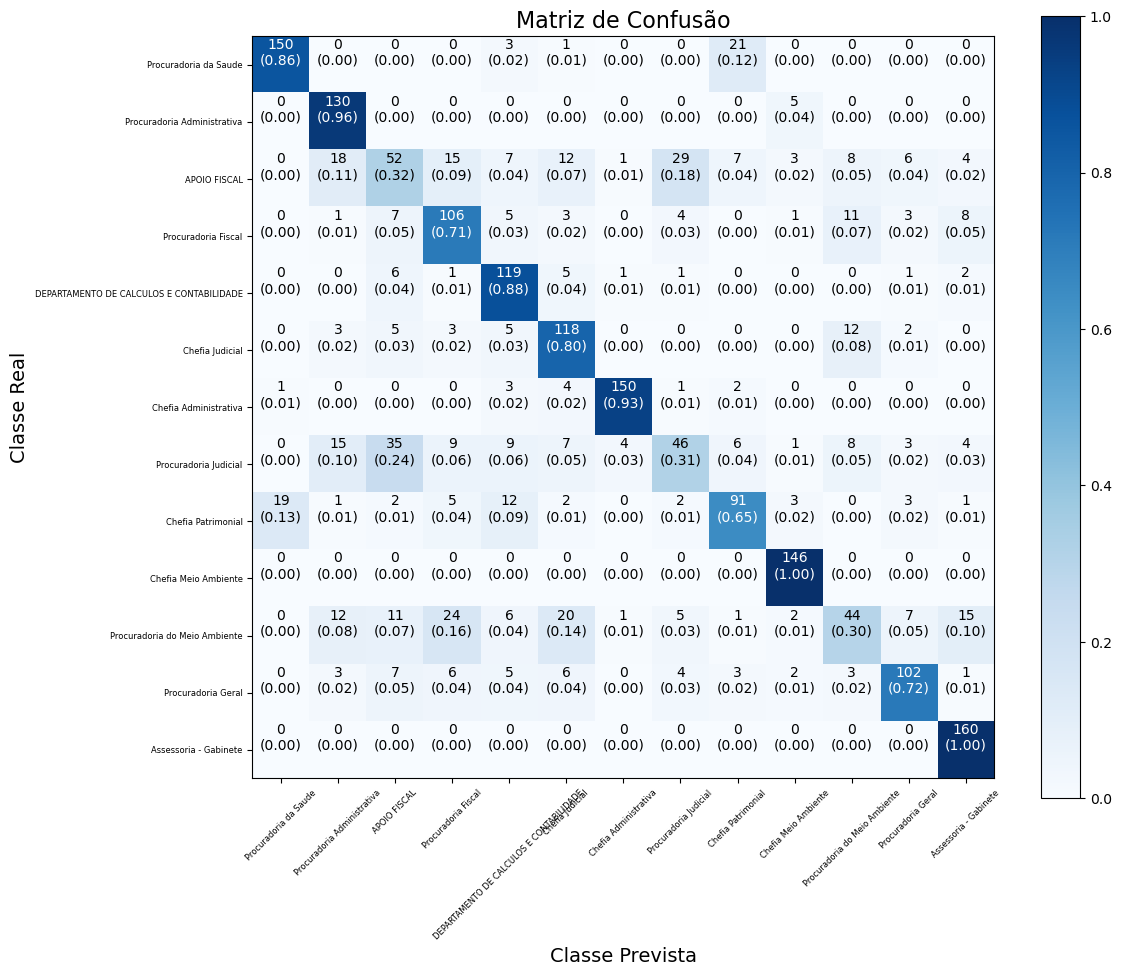

In [22]:
plot_confusion_matrix(y_test=y_test, y_pred=y_pred, class_names=classes)

### 4.4.2 - SVM

In [23]:
svm_clf = SVC()

svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

In [24]:
print(classification_report(y_true=y_test, y_pred=y_pred))

                                          precision    recall  f1-score   support

                            APOIO FISCAL       0.94      0.88      0.91       175
                   Assessoria - Gabinete       0.71      0.90      0.79       135
                   Chefia Administrativa       0.48      0.25      0.33       162
                         Chefia Judicial       0.59      0.69      0.63       149
                    Chefia Meio Ambiente       0.83      0.90      0.86       136
                      Chefia Patrimonial       0.91      0.71      0.80       148
DEPARTAMENTO DE CALCULOS E CONTABILIDADE       0.96      0.98      0.97       161
             Procuradoria Administrativa       0.44      0.39      0.41       147
                     Procuradoria Fiscal       0.67      0.77      0.72       141
                      Procuradoria Geral       0.95      1.00      0.97       146
                   Procuradoria Judicial       0.51      0.49      0.50       148
               

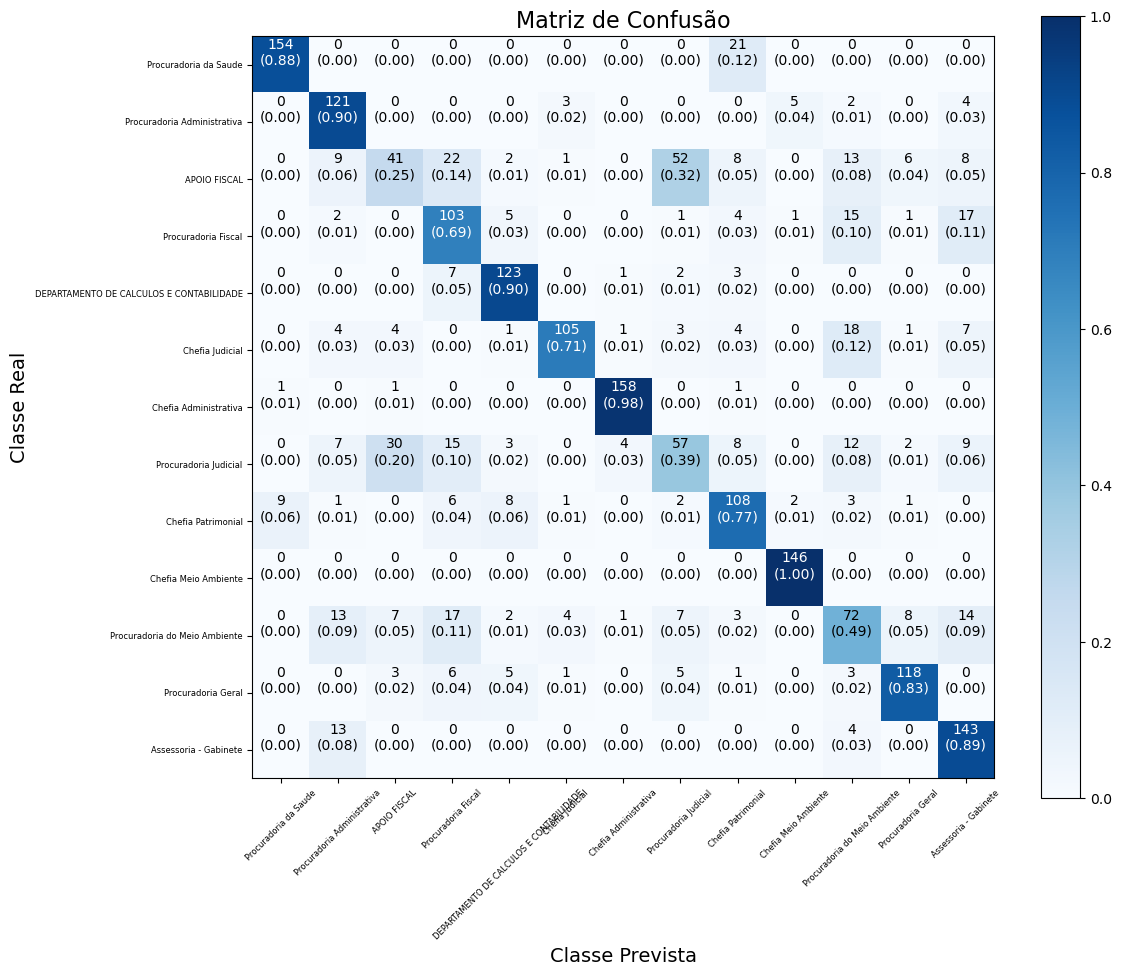

In [25]:
plot_confusion_matrix(y_test=y_test, y_pred=y_pred, class_names=classes)

### 4.4.3 - Naive Bayes

In [26]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)

y_pred = nb_clf.predict(X_test)

In [27]:
print(classification_report(y_true=y_test, y_pred=y_pred))

                                          precision    recall  f1-score   support

                            APOIO FISCAL       0.80      0.87      0.83       175
                   Assessoria - Gabinete       0.56      0.72      0.63       135
                   Chefia Administrativa       0.38      0.14      0.21       162
                         Chefia Judicial       0.40      0.60      0.48       149
                    Chefia Meio Ambiente       0.66      0.57      0.61       136
                      Chefia Patrimonial       0.81      0.49      0.61       148
DEPARTAMENTO DE CALCULOS E CONTABILIDADE       0.90      0.98      0.93       161
             Procuradoria Administrativa       0.49      0.39      0.43       147
                     Procuradoria Fiscal       0.56      0.60      0.58       141
                      Procuradoria Geral       0.92      0.84      0.88       146
                   Procuradoria Judicial       0.41      0.40      0.40       148
               

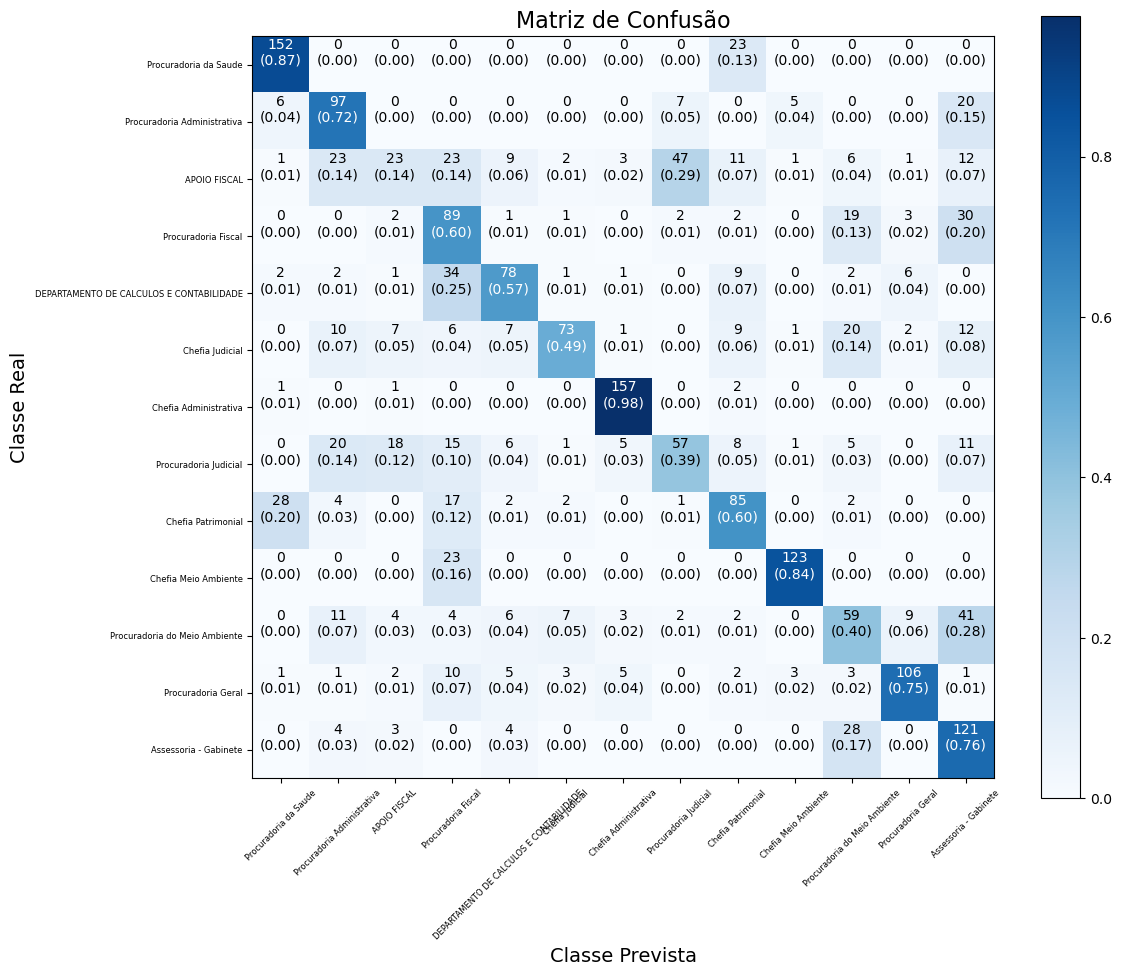

In [28]:
plot_confusion_matrix(y_test=y_test, y_pred=y_pred, class_names=classes)

### 4.4.4 - Random Forest

In [29]:
random_forest_clf = RandomForestClassifier()
random_forest_clf.fit(X_train, y_train)

y_pred = random_forest_clf.predict(X_test)

In [30]:
print(classification_report(y_true=y_test, y_pred=y_pred))

                                          precision    recall  f1-score   support

                            APOIO FISCAL       0.94      0.86      0.90       175
                   Assessoria - Gabinete       0.95      0.96      0.96       135
                   Chefia Administrativa       0.39      0.27      0.32       162
                         Chefia Judicial       0.73      0.87      0.80       149
                    Chefia Meio Ambiente       0.84      0.92      0.88       136
                      Chefia Patrimonial       0.86      0.97      0.91       148
DEPARTAMENTO DE CALCULOS E CONTABILIDADE       0.97      0.94      0.96       161
             Procuradoria Administrativa       0.43      0.42      0.43       147
                     Procuradoria Fiscal       0.67      0.77      0.72       141
                      Procuradoria Geral       0.95      1.00      0.98       146
                   Procuradoria Judicial       0.62      0.51      0.56       148
               

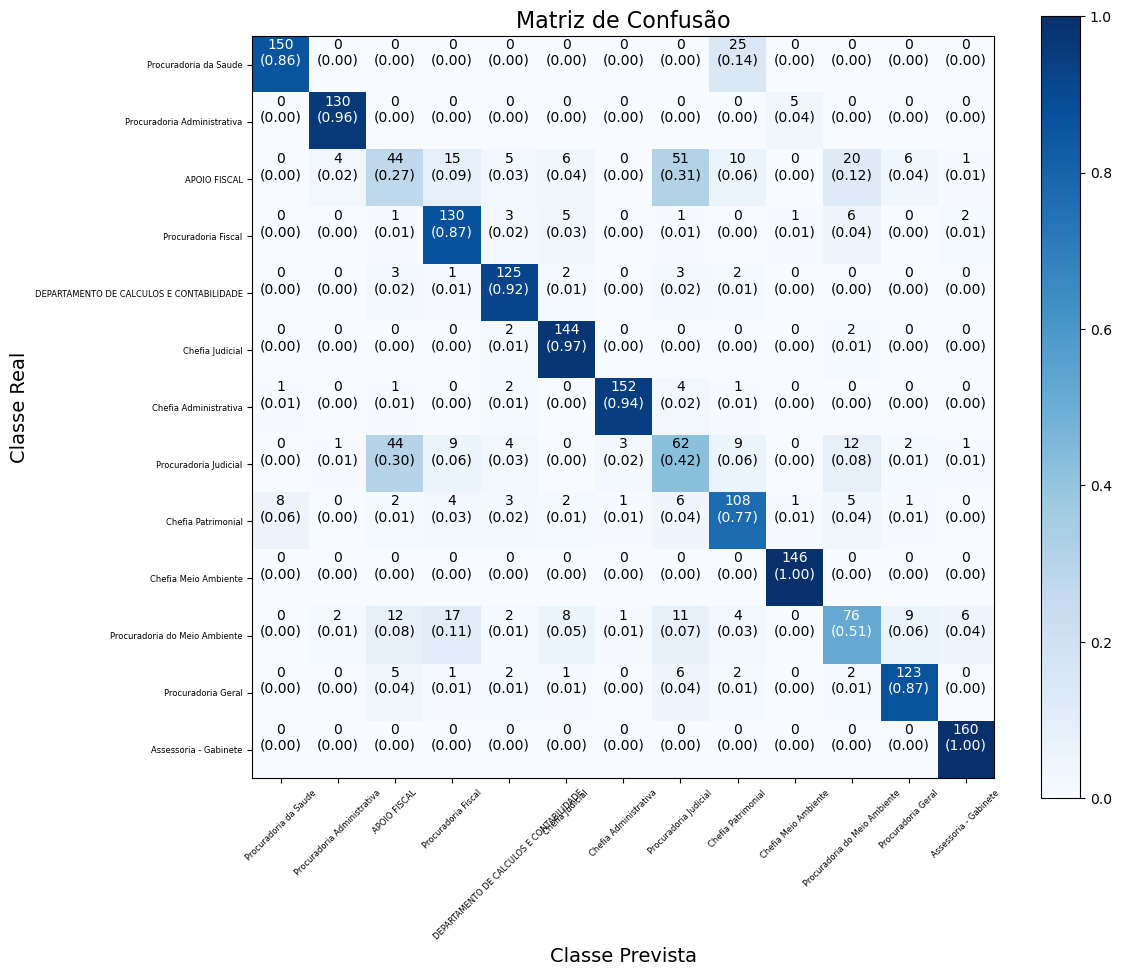

In [31]:
plot_confusion_matrix(y_test=y_test, y_pred=y_pred, class_names=classes)

### 4.4.5 - XGBoost

In [32]:
sub_dict = {classe: i for i, classe in enumerate(classes)}

y_train_temp = [sub_dict[i] for i in y_train]
y_test_temp = [sub_dict[i] for i in y_test]

xgboost_clf = XGBClassifier()
xgboost_clf.fit(X_train, y_train_temp)

y_pred = xgboost_clf.predict(X_test)

In [33]:
print(classification_report(y_true=y_test_temp, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       142
           1       0.40      0.36      0.38       147
           2       0.92      0.86      0.89       175
           3       0.69      0.76      0.73       141
           4       0.96      0.98      0.97       161
           5       0.74      0.89      0.81       149
           6       0.45      0.35      0.39       162
           7       0.71      0.64      0.67       148
           8       0.91      0.97      0.94       148
           9       0.90      0.95      0.92       136
          10       0.96      1.00      0.98       160
          11       0.95      1.00      0.97       146
          12       0.94      0.96      0.95       135

    accuracy                           0.81      1950
   macro avg       0.80      0.81      0.81      1950
weighted avg       0.80      0.81      0.80      1950



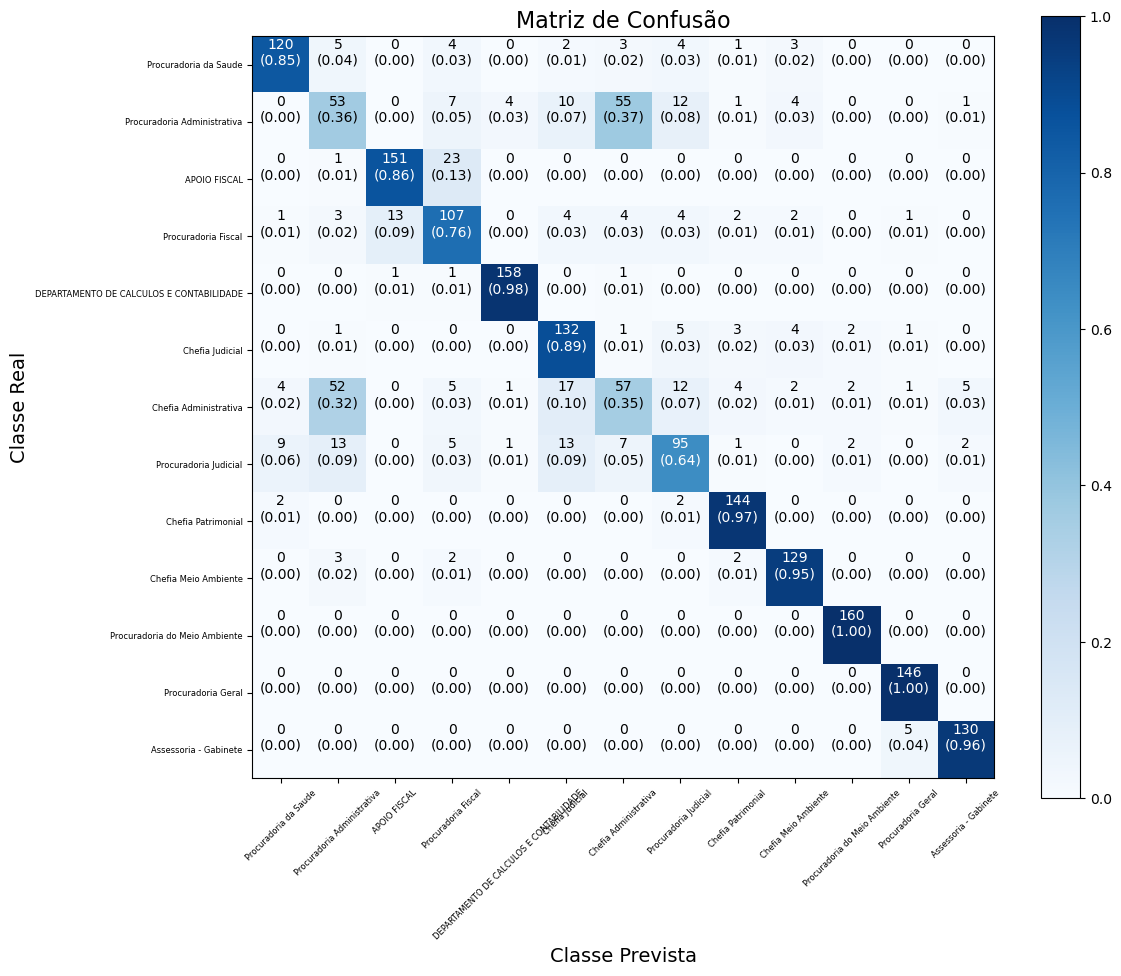

In [34]:
plot_confusion_matrix(y_test=y_test_temp, y_pred=y_pred, class_names=classes)

### 4.4.6 - MLP

In [35]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,100),
                        solver='adam',
                        verbose=True)

mlp_clf.fit(X_train, y_train)
y_pred = mlp_clf.predict(X_test)

Iteration 1, loss = 2.40406799
Iteration 2, loss = 1.74467646
Iteration 3, loss = 1.14986139
Iteration 4, loss = 0.85668648
Iteration 5, loss = 0.71923572
Iteration 6, loss = 0.63541688
Iteration 7, loss = 0.57431426
Iteration 8, loss = 0.53041077
Iteration 9, loss = 0.49647551
Iteration 10, loss = 0.48002435
Iteration 11, loss = 0.45136846
Iteration 12, loss = 0.42484820
Iteration 13, loss = 0.40642689
Iteration 14, loss = 0.39579183
Iteration 15, loss = 0.38385624
Iteration 16, loss = 0.36914004
Iteration 17, loss = 0.36003237
Iteration 18, loss = 0.34579395
Iteration 19, loss = 0.33608578
Iteration 20, loss = 0.33290726
Iteration 21, loss = 0.32387561
Iteration 22, loss = 0.31972600
Iteration 23, loss = 0.31158407
Iteration 24, loss = 0.29903597
Iteration 25, loss = 0.29371297
Iteration 26, loss = 0.29173715
Iteration 27, loss = 0.28588774
Iteration 28, loss = 0.28405140
Iteration 29, loss = 0.28197480
Iteration 30, loss = 0.27799455
Iteration 31, loss = 0.26964911
Iteration 32, los

In [36]:
print(classification_report(y_true=y_test, y_pred=y_pred))

                                          precision    recall  f1-score   support

                            APOIO FISCAL       0.90      0.88      0.89       175
                   Assessoria - Gabinete       0.93      0.96      0.95       135
                   Chefia Administrativa       0.41      0.30      0.34       162
                         Chefia Judicial       0.71      0.85      0.78       149
                    Chefia Meio Ambiente       0.86      0.92      0.89       136
                      Chefia Patrimonial       0.88      0.97      0.92       148
DEPARTAMENTO DE CALCULOS E CONTABILIDADE       0.95      0.92      0.93       161
             Procuradoria Administrativa       0.35      0.35      0.35       147
                     Procuradoria Fiscal       0.70      0.72      0.71       141
                      Procuradoria Geral       0.97      1.00      0.98       146
                   Procuradoria Judicial       0.60      0.52      0.56       148
               

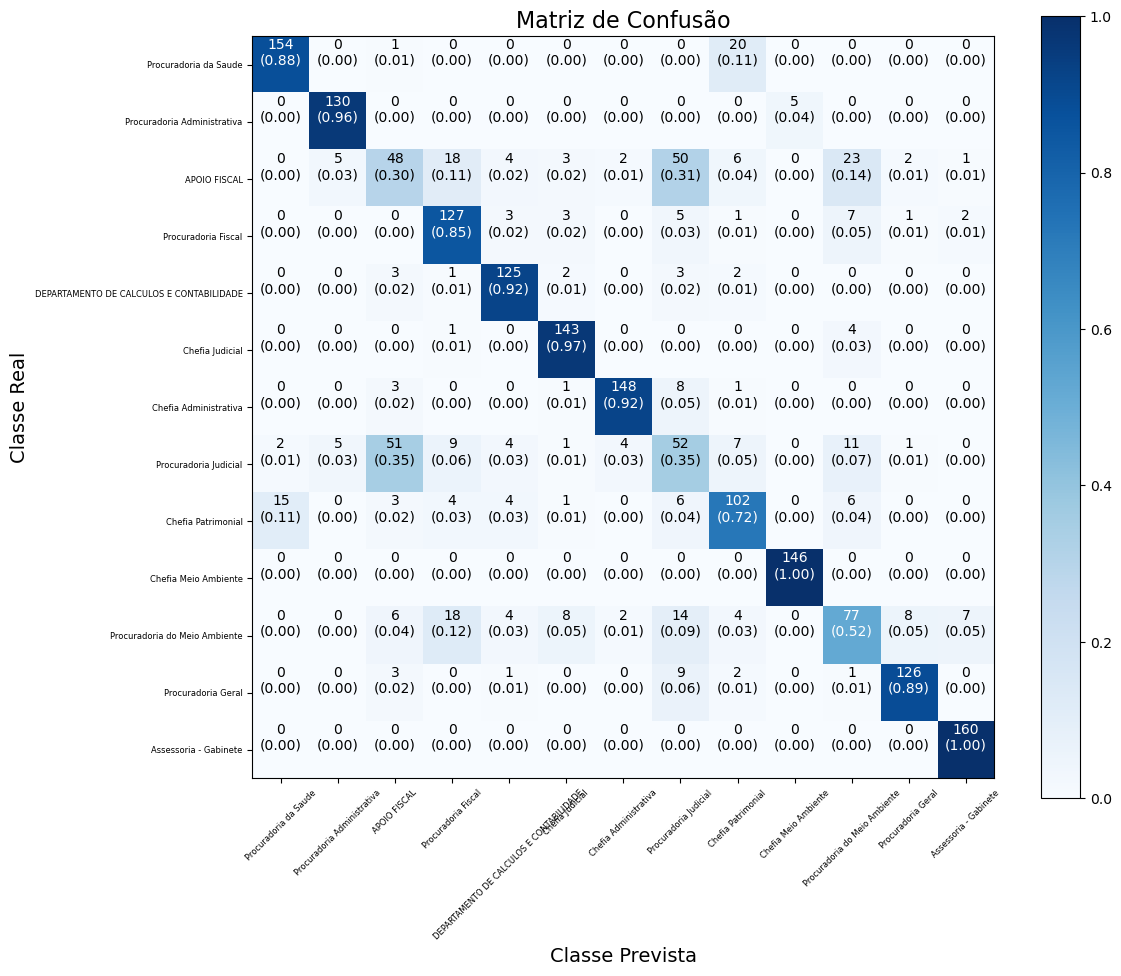

In [37]:
plot_confusion_matrix(y_test=y_test, y_pred=y_pred, class_names=classes)

## 4.5 - Feature Extraction usando BERT

In [38]:
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

X_train = bert_model.encode(X_train_text, show_progress_bar=True)
X_test = bert_model.encode(X_test_text, show_progress_bar=True)

print(f'Shape das embeddings de treinamento: {X_train.shape}')
print(f'Shape das embeddings de teste: {X_test.shape}')

c:\Users\EsdrasDaniel\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/143 [00:00<?, ?it/s]

Batches:   0%|          | 0/61 [00:00<?, ?it/s]

Shape das embeddings de treinamento: (4550, 384)
Shape das embeddings de teste: (1950, 384)


### 4.5.1 - Random Forest

In [39]:
# Random Forest
random_forest_clf = RandomForestClassifier()
random_forest_clf.fit(X_train, y_train)

y_pred = random_forest_clf.predict(X_test)

In [40]:
print(classification_report(y_true=y_test, y_pred=y_pred))

                                          precision    recall  f1-score   support

                            APOIO FISCAL       0.85      0.85      0.85       175
                   Assessoria - Gabinete       0.98      0.96      0.97       135
                   Chefia Administrativa       0.45      0.33      0.38       162
                         Chefia Judicial       0.82      0.92      0.87       149
                    Chefia Meio Ambiente       0.90      0.95      0.92       136
                      Chefia Patrimonial       0.95      0.97      0.96       148
DEPARTAMENTO DE CALCULOS E CONTABILIDADE       0.97      0.94      0.96       161
             Procuradoria Administrativa       0.37      0.37      0.37       147
                     Procuradoria Fiscal       0.62      0.68      0.65       141
                      Procuradoria Geral       0.95      1.00      0.98       146
                   Procuradoria Judicial       0.56      0.57      0.56       148
               

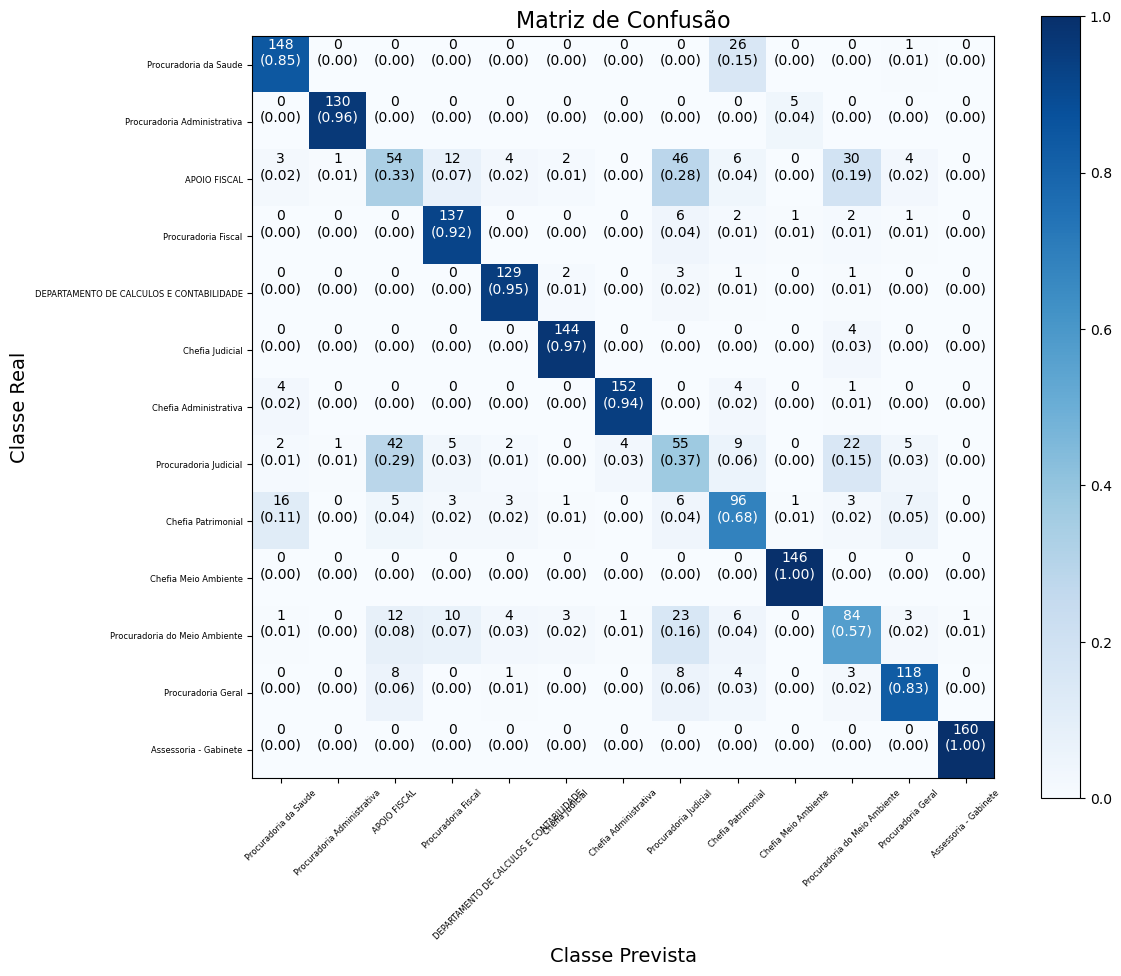

In [41]:
plot_confusion_matrix(y_test=y_test, y_pred=y_pred, class_names=classes)

### 4.5.2 - XGBoost

In [42]:
# XGBOOST

sub_dict = {classe: i for i, classe in enumerate(classes)}

y_train_temp = [sub_dict[i] for i in y_train]
y_test_temp = [sub_dict[i] for i in y_test]

xgboost_clf = XGBClassifier()
xgboost_clf.fit(X_train, y_train_temp)

y_pred = xgboost_clf.predict(X_test)

In [43]:
print(classification_report(y_true=y_test_temp, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.82       142
           1       0.39      0.39      0.39       147
           2       0.89      0.82      0.85       175
           3       0.58      0.70      0.63       141
           4       0.96      0.96      0.96       161
           5       0.83      0.93      0.87       149
           6       0.46      0.33      0.39       162
           7       0.59      0.52      0.55       148
           8       0.94      0.97      0.96       148
           9       0.88      0.92      0.90       136
          10       0.97      1.00      0.98       160
          11       0.95      1.00      0.98       146
          12       0.98      0.96      0.97       135

    accuracy                           0.79      1950
   macro avg       0.79      0.80      0.79      1950
weighted avg       0.79      0.79      0.79      1950



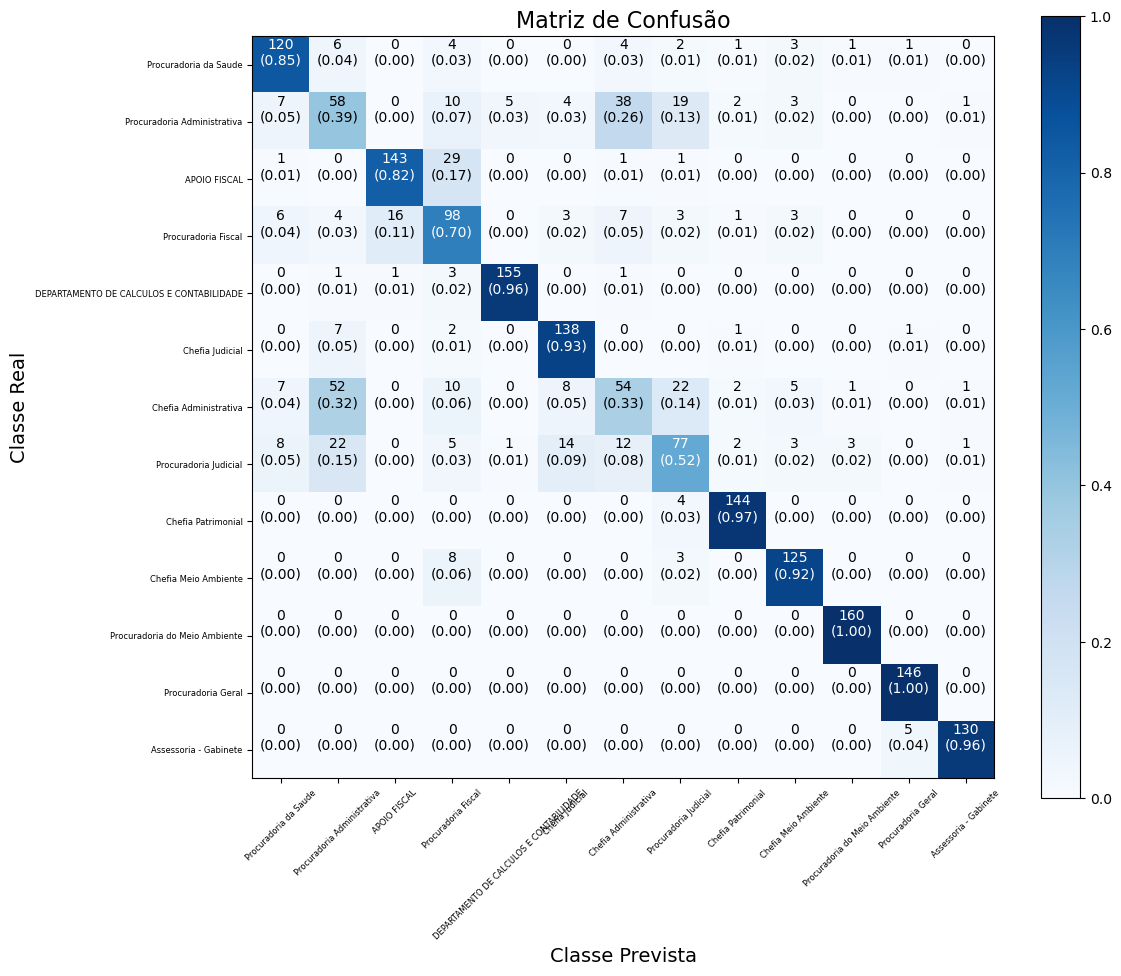

In [44]:
plot_confusion_matrix(y_test=y_test_temp, y_pred=y_pred, class_names=classes)

### 4.5.3 - MLP

In [51]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,100),
                        solver='adam',
                        max_iter=500,
                        verbose=True,)

mlp_clf.fit(X_train, y_train)
y_pred = mlp_clf.predict(X_test)

Iteration 1, loss = 2.52929999
Iteration 2, loss = 2.34818345
Iteration 3, loss = 2.06602207
Iteration 4, loss = 1.81043530
Iteration 5, loss = 1.63775710
Iteration 6, loss = 1.51568512
Iteration 7, loss = 1.42267341
Iteration 8, loss = 1.34290764
Iteration 9, loss = 1.27805359
Iteration 10, loss = 1.22344568
Iteration 11, loss = 1.17718227
Iteration 12, loss = 1.13879256
Iteration 13, loss = 1.09704434
Iteration 14, loss = 1.06409169
Iteration 15, loss = 1.03554610
Iteration 16, loss = 1.01152348
Iteration 17, loss = 0.98232418
Iteration 18, loss = 0.95584029
Iteration 19, loss = 0.93927189
Iteration 20, loss = 0.92457240
Iteration 21, loss = 0.91066021
Iteration 22, loss = 0.89073980
Iteration 23, loss = 0.87253118
Iteration 24, loss = 0.86354760
Iteration 25, loss = 0.84848253
Iteration 26, loss = 0.83416577
Iteration 27, loss = 0.82328205
Iteration 28, loss = 0.80745793
Iteration 29, loss = 0.80099704
Iteration 30, loss = 0.78719834
Iteration 31, loss = 0.77837455
Iteration 32, los

In [52]:
print(classification_report(y_true=y_test, y_pred=y_pred))

                                          precision    recall  f1-score   support

                            APOIO FISCAL       0.89      0.78      0.83       175
                   Assessoria - Gabinete       0.87      0.96      0.92       135
                   Chefia Administrativa       0.46      0.40      0.42       162
                         Chefia Judicial       0.69      0.86      0.76       149
                    Chefia Meio Ambiente       0.83      0.92      0.87       136
                      Chefia Patrimonial       0.83      0.98      0.90       148
DEPARTAMENTO DE CALCULOS E CONTABILIDADE       0.96      0.95      0.96       161
             Procuradoria Administrativa       0.37      0.28      0.32       147
                     Procuradoria Fiscal       0.58      0.62      0.60       141
                      Procuradoria Geral       0.93      1.00      0.96       146
                   Procuradoria Judicial       0.60      0.33      0.43       148
               

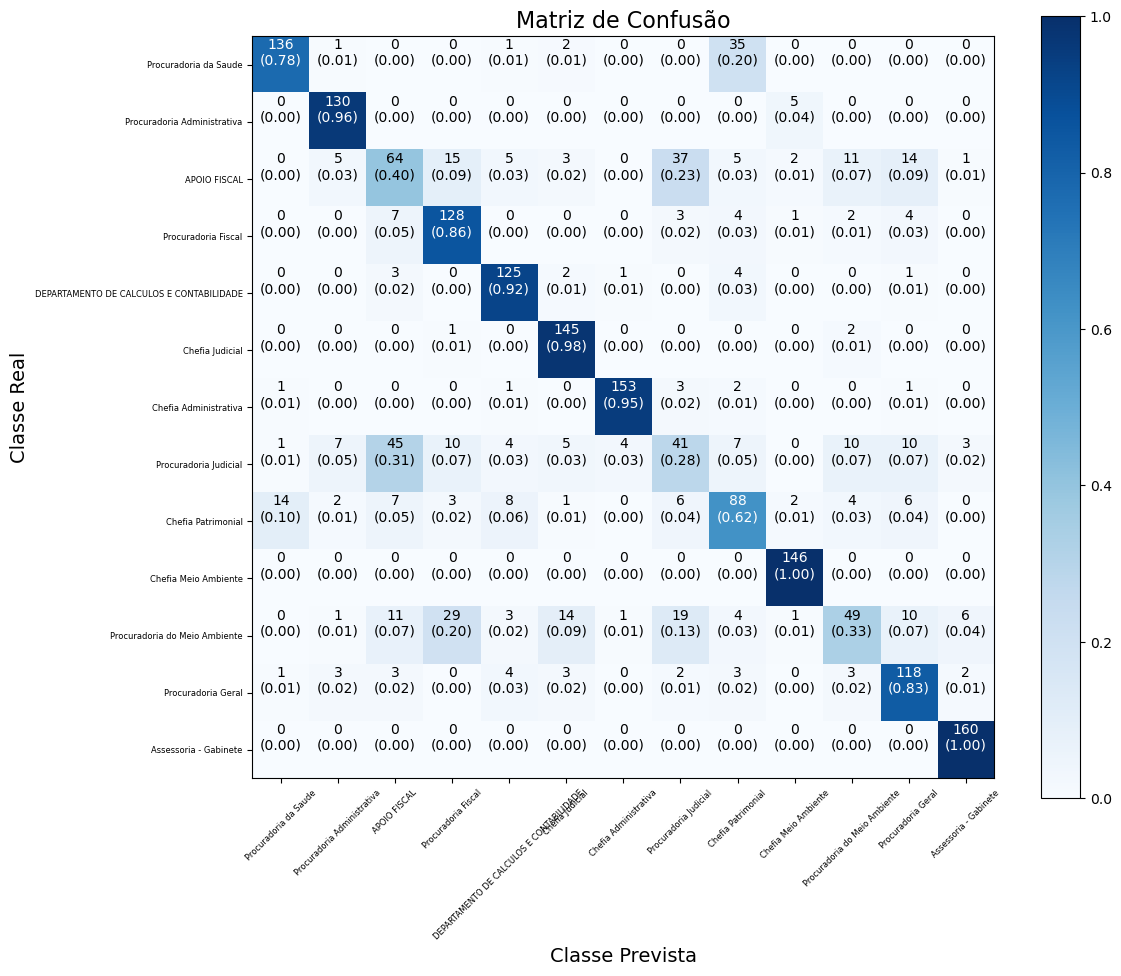

In [53]:
plot_confusion_matrix(y_test=y_test, y_pred=y_pred, class_names=classes)